# PINN方法求解PDE

In [15]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, Sequential
from torch.utils.tensorboard import SummaryWriter
import torch.functional as F

设有函数$u(x,y)$满足如下PDE:
$$
\begin{aligned}
\frac{\partial^{2} u}{\partial x^{2}} &-\frac{\partial^{4} u}{\partial y^{4}}=\left(2-x^{2}\right) e^{-y} \\
u_{y y}(x, 0) &=x^{2}, u_{y y}(x, 1)=x^{2} / e \\
u(x, 0) &=x^{2}, u(x, 1)=x^{2} / e \\
u(0, y) &=0, u(1, y)=e^{-y}
\end{aligned}
$$
其真解为 $u(x,y) = x^2 \exp(-y)$.  
考虑定义一个神经网络 $\overset{\sim}{u}(x,y,\theta),$可以利用神经网络的自动微分功能求解
$\overset{\sim}{u}_x^{(4)},\overset{\sim}{u}_y^{(4)},\overset{\sim}{u}_y^{(2)}$,
从而在$[0,1]^2$上面构造如下损失函数：
$$
\begin{aligned}
L_{1} &=\frac{1}{N_{1}} \sum_{\left(x_{i}, y_{i}\right) \in \Omega}\left(\tilde{u}_{x x}\left(x_{i}, y_{i} ; \theta\right)-\tilde{u}_{y y y y}\left(x_{i}, y_{i} ; \theta\right)-\left(2-x_{i}^{2}\right) e^{-y_{i}}\right)^{2} \\
L_{2} &=\frac{1}{N_{2}} \sum_{\left(x_{i}, y_{i}\right) \in[0,1] \times\{0\}}\left(\tilde{u}_{y y}\left(x_{i}, y_{i} ; \theta\right)-x_{i}^{2}\right)^{2} \\
L_{3} &=\frac{1}{N_{3}} \sum_{\left(x_{i}, y_{i}\right) \in[0,1] \times\{1\}}\left(\tilde{u}_{y y}\left(x_{i}, y_{i} ; \theta\right)-\frac{x_{i}^{2}}{e}\right)^{2} \\
L_{4} &=\frac{1}{N_{4}} \sum_{\left(x_{i}, y_{i}\right) \in[0,1] \times\{0\}}\left(\tilde{u}\left(x_{i}, y_{i} ; \theta\right)-x_{i}^{2}\right)^{2} \\
L_{5} &=\frac{1}{N_{5}} \sum_{\left(x_{i}, y_{i}\right) \in[0,1] \times\{1\}}\left(\tilde{u}\left(x_{i}, y_{i} ; \theta\right)-\frac{x_{i}^{2}}{e}\right)^{2} \\
L_{6} &=\frac{1}{N_{6}} \sum_{\left(x_{i}, y_{i}\right) \in\{0\} \times[0,1]}\left(\tilde{u}\left(x_{i}, y_{i} ; \theta\right)-0\right)^{2} \\
L_{7} &=\frac{1}{N_{7}} \sum_{\left(x_{i}, y_{i}\right) \in\{1\} \times[0,1]}\left(\tilde{u}\left(x_{i}, y_{i} ; \theta\right)-\exp \left(-y_{i}\right)\right)^{2}
\end{aligned}
$$

## 采样

In [16]:
def interior(n=1000):
    x = torch.rand(n, 1)
    y = torch.rand(n, 1)
    cond = (2 - x**2) * torch.exp(-y)
    return x.requires_grad_(True), y.requires_grad_(True), cond


def down_yy(n=100):
    x = torch.rand(n, 1)
    y = torch.zeros_like(x)
    cond = x**2
    return x.requires_grad_(True), y.requires_grad_(True), cond


def up_yy(n=100):
    x = torch.rand(n, 1)
    y = torch.ones_like(x)
    cond = x**2 / torch.e
    return x.requires_grad_(True), y.requires_grad_(True), cond


def down(n=100):
    x = torch.rand(n, 1)
    y = torch.zeros_like(x)
    cond = x**2
    return x.requires_grad_(True), y.requires_grad_(True), cond


def up(n=100):
    x = torch.rand(n, 1)
    y = torch.ones_like(x)
    cond = x**2 / torch.e
    return x.requires_grad_(True), y.requires_grad_(True), cond


def left(n=100):
    y = torch.rand(n, 1)
    x = torch.zeros_like(y)
    cond = torch.zeros_like(x)
    return x.requires_grad_(True), y.requires_grad_(True), cond


def right(n=100):
    y = torch.rand(n, 1)
    x = torch.ones_like(y)
    cond = torch.exp(-y)
    return x.requires_grad_(True), y.requires_grad_(True), cond

## 定义网络

In [17]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = torch.nn.Sequential(torch.nn.Linear(2, 32), torch.nn.Tanh(),
                                       torch.nn.Linear(32,
                                                       32), torch.nn.Tanh(),
                                       torch.nn.Linear(32,
                                                       32), torch.nn.Tanh(),
                                       torch.nn.Linear(32, 32),
                                       torch.nn.Tanh(), torch.nn.Linear(32, 1))

    def forward(self, x):
        return self.net(x)

## 损失函数

In [18]:
loss = torch.nn.MSELoss()


def gradients(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(
            u,
            x,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            only_inputs=True,
        )[0]
    else:
        return gradients(gradients(u, x), x, order=order - 1)


def l_interior(u):
    x, y, cond = interior()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(gradients(uxy, x, 2) - gradients(uxy, y, 4), cond)


def l_down_yy(u):
    x, y, cond = down_yy()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(gradients(uxy, y, 2), cond)


def l_up_yy(u):
    x, y, cond = up_yy()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(gradients(uxy, y, 2), cond)


def l_down(u):
    x, y, cond = down()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)


def l_up(u):
    x, y, cond = up()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)


def l_left(u):
    x, y, cond = left()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)


def l_right(u):
    x, y, cond = right()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)

## 训练

In [20]:
u = MLP()
opt = torch.optim.Adam(params=u.parameters())

for i in range(1000):
    opt.zero_grad()
    l = l_interior(u) + l_up_yy(u) + l_down_yy(u) + l_up(u) + l_down(
        u) + l_left(u) + l_right(u)
    l.backward()
    opt.step()

## 测试

### 测试格点定义

In [21]:
xc = torch.linspace(0, 1, 100)
xx, yy = torch.meshgrid(xc, xc)
xx = xx.reshape(-1, 1)
yy = yy.reshape(-1, 1)
xy = torch.cat([xx, yy], dim=1)
# xy.shape     torch.Size([10000, 2])

/Users/mia/opt/anaconda3/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646756029501/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### 1000步结果展示

In [23]:
import seaborn as sns
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

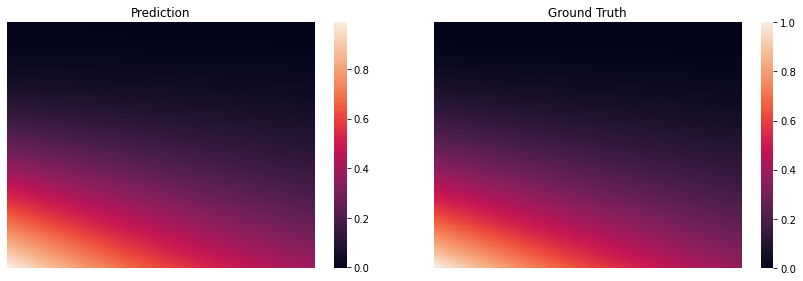

In [24]:
figure, ax = plt.subplots(1, 2, figsize=(12, 4))
figure.tight_layout()
ax[0].set_title("Prediction")
ax[1].set_title("Ground Truth")
plt.subplot(121)
u_pred = u(xy)
h1 = sns.heatmap(u_pred.reshape(100, 100).detach().numpy(),
                 xticklabels=False,
                 yticklabels=False)
u_real = xx * xx * torch.exp(-yy)
plt.subplot(122)
h2 = sns.heatmap(u_real.reshape(100, 100).detach().numpy(),
                 xticklabels=False,
                 yticklabels=False)

### 误差情况

In [70]:
iter_list = [32,64,128,256,512,1024,2048,4096,8192]

In [ ]:
u = MLP()
opt = torch.optim.Adam(params=u.parameters())
Loss_Max = []
Loss_L1 = []
u_real = xx * xx * torch.exp(-yy)
for i in range(8192):
    opt.zero_grad()
    l = l_interior(u) + l_up_yy(u) + l_down_yy(u) + l_up(u) + l_down(
        u) + l_left(u) + l_right(u)
    l.backward()
    opt.step()
    if i+1 in iter_list:
        u_tmp = u(xy)
        Loss_Max.append(float(torch.max(torch.abs(u_tmp - u_real))))
        Loss_L1.append(float(torch.mean(torch.abs(u_tmp - u_real))))
    if i%100 == 0 and i > 0:
        print('{}% completed'.format(round(i*100/8192)))
print('100% completed')

In [76]:
print(Loss_Max)
print(Loss_L1)

[0.2711995840072632, 0.353751540184021, 0.2919490337371826, 0.1601947546005249, 0.026241034269332886, 0.009068034589290619, 0.008830681443214417, 0.0055384039878845215, 0.0018173009157180786]
[0.10804910957813263, 0.05871691182255745, 0.05684356018900871, 0.03157415613532066, 0.008948626928031445, 0.005725524853914976, 0.005501886364072561, 0.003008290659636259, 0.0004961903905496001]


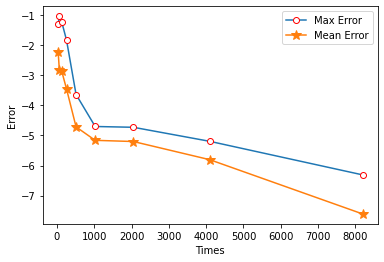

In [81]:
plt.plot(iter_list,np.log(Loss_Max), marker='o', mec='r', mfc='w',label=u'Max Error')
plt.plot(iter_list, np.log(Loss_L1), marker='*', ms=10,label=u'Mean Error')
plt.legend() 
plt.xlabel(u"Times") 
plt.ylabel("Error") 
plt.show()